# Intensity Dependent Photoluminescence (IDPL) Analysis

### Libraries

In [29]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import math
import os

## Importing and Plotting IDPL data

,C,C+P,NS,NS+P,P,P+P,PS,PS+P
10,C_idpl_10_.txt,C+P_idpl_10_.txt,NS_idpl_10_.txt,NS+P_idpl_10_.txt,P_idpl_10_1.txt,P+P_idpl_10_.txt,PS_idpl_10_.txt,PS+P_idpl_10_.txt
25,C_idpl_25_.txt,C+P_idpl_25_.txt,NS_idpl_25_.txt,NS+P_idpl_25_.txt,P_idpl_25_.txt,P+P_idpl_25_.txt,PS_idpl_25_.txt,PS+P_idpl_25.txt
50,C_idpl_50_.txt,C+P_idpl_50_.txt,NS_idpl_50_.txt,NS+P_idpl_50_.txt,P_idpl_50_.txt,P+P_idpl_50_.txt,PS_idpl_50_.txt,PS+P_idpl_50_.txt
75,C_idpl_75_.txt,C+P_idpl_75_.txt,NaN,NS+P_idpl_75_.txt,P_idpl_75_.txt,P+P_idpl_75_.txt,PS_idpl_75_.txt,PS+P_idpl_75_.txt
100,C_idpl_100_.txt,C+P_idpl_100_.txt,NS_idpl_100_.txt,NS+P_idpl_100_.txt,P_idpl_100_.txt,P+P_idpl_100_.txt,PS_idpl_100_.txt,PS+P_idpl_100_.txt
125,C_idpl_125_.txt,C+P_idpl_125_.txt,NS_idpl_125_.txt,NS+P_idpl_125_.txt,P_idpl_125_.txt,P+P_idpl_125_.txt,PS_idpl_125_.txt,PS+P_idpl_125_.txt
150,C_idpl_150_.txt,C+P_idpl_150_.txt,NS_idpl_150_.txt,NS+P_idpl_150_.txt,P_idpl_150_.txt,P+P_idpl_150_.txt,PS_idpl_150_.txt,PS+P_idpl_150_.txt


,C_pk,C_infl,C+P_pk,C+P_infl,NS_pk,NS_infl,NS+P_pk,NS+P_infl,P_pk,P_infl,P+P_pk,P+P_infl,PS_pk,PS_infl,PS+P_pk,PS+P_infl
10,893.790085,873.031386,894.733292,862.961067,895.362078,859.498585,893.161262,867.681968,882.469075,859.813373,891.589142,861.072491,886.243261,843.804261,882.469075,859.183793
25,891.903573,862.331555,893.161262,863.905309,894.104491,868.311363,891.274707,862.331555,873.975297,852.257529,892.218001,862.331555,884.041715,847.865176,880.267231,859.498585
50,889.388023,862.331555,891.274707,862.961067,891.274707,859.183793,888.759099,859.813373,873.660663,849.426920,889.388023,861.072491,880.896347,843.491860,876.492239,851.627788
75,889.073563,861.387262,889.073563,862.961067,NaN,NaN,884.041715,859.183793,870.828806,848.489883,888.759099,861.072491,879.323530,843.491860,874.919176,844.741444
100,888.444632,858.868998,886.243261,859.813373,888.444632,859.183793,880.581791,858.868998,869.570112,847.240455,885.928765,860.442939,873.346026,835.993284,870.199466,844.741444
125,885.299763,858.554200,882.469075,860.442939,885.928765,859.183793,876.806841,847.865176,868.626055,825.367183,883.727194,860.442939,871.143470,835.368319,870.199466,845.366216
150,885.299763,858.554200,880.581791,859.813373,885.299763,858.868998,871.458132,844.429053,865.793700,825.679767,882.783610,856.980158,869.255430,833.180845,865.164250,829.430531


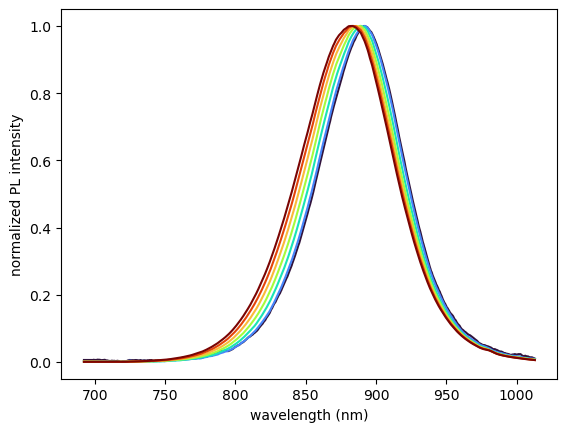

In [74]:
PLsave=pd.DataFrame()
def sort(val):
    return int(val.split('_')[2].strip('.txt'))

power=[
    '10',
    '25',
    '50',
    '75',
    '100',
    '125',
    '150']

path='C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\2022\\0607_all\\'

folderlist=[file for file in os.listdir(path) if (os.path.isfile(path+file)==False and file!='UVvis' and file!='extra')]
flist=pd.DataFrame()

for folname in folderlist:
    pow=[]
    filelist=[file for file in os.listdir(path+folname) if 'idpl' in file]
    for f in filelist:
        pow.append(int(f.split('_')[2].strip('.txt')))
    pow.sort()
    filelist.sort(key=sort)
    filelist=pd.Series(filelist,index=pow)
    flist[folname]=filelist

display(flist)

PLmaster=pd.DataFrame(index=power)

n=len(power)
color=plt.cm.turbo(np.linspace(0, 1, n))

for fol in folderlist:
    PLdf=pd.DataFrame()
    collection_pk=[]
    collection_infl=[]
    ii=0
    for p in power:
        if pd.isna(flist[fol][int(p)]):
            collection_pk.append(np.nan)
            collection_infl.append(np.nan)
            continue
        PLdata=pd.read_csv(path+fol+'\\'+str(flist[fol][int(p)]),header=None,names=['nm','intensity'],sep="\t")
        wav=pd.Series(PLdata['nm'],dtype=float)
        PLint=pd.Series(PLdata['intensity'],dtype=float)
        
        # rolling average smoothing + background subtracting
        PLint = PLint.iloc[:].rolling(window=20).mean().fillna(method='bfill')
        PLint = PLint.sub(PLint.min())
        
        # normalizing PL and adding to dataframe
        PLnorm=[]
        for i in range(len(PLint)):
            PLnorm.append((PLint[i]-PLint.min())/(PLint.max()-PLint.min()))
        PLnorm=pd.Series(PLnorm)

        # select sample type to plot and save. remove if statement to display and save all data.
        if fol=='P+P':
            plt.plot(wav,PLnorm,c=color[ii])
            ii+=1
            plt.xlabel("wavelength (nm)")
            plt.ylabel("normalized PL intensity")
            PLsave[p]=PLnorm
            wav.to_csv(path+'wavelength.csv')
            PLsave.to_csv(path+'PP_IDPL.csv')
        
        # find peak and peak index
        collection_pk.append(wav.iloc[PLnorm.idxmax()])
        
        # find inflection point
        diffPL=PLnorm.copy()
        diffPL=diffPL.diff(periods=1).dropna()
        diffPL=diffPL.iloc[:].rolling(window=20).mean().fillna(method='bfill')
        collection_infl.append(wav.iloc[diffPL.idxmax()])
            
    PLmaster[fol+'_pk']=collection_pk
    PLmaster[fol+'_infl']=collection_infl
# plt.savefig(path+'PP_plot.png',dpi=400)
display(PLmaster)


## Plotting IDPL Extracted Parameters

Plotting change in peak position (nm) and change in inflection point position (nm) from the lowest to the highest incident intensity for each sample. Both parameters are extracted from the cell above.

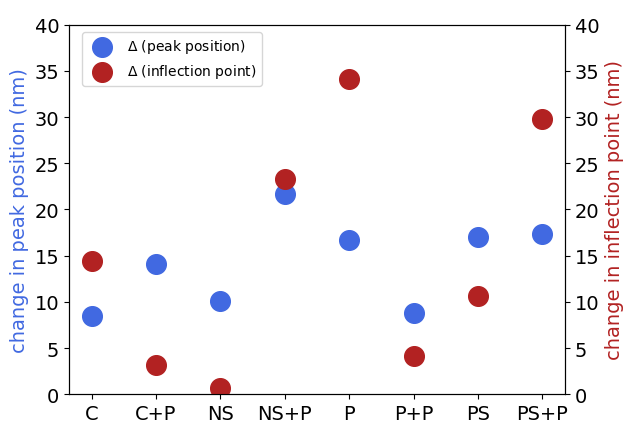

In [24]:
delpeak=[]
delinfl=[]

for series in PLmaster: 
    if series.endswith('_pk'):
        delpeak.append(PLmaster[series][0]-PLmaster[series][-1])
    elif series.endswith('_infl'):
        delinfl.append(PLmaster[series][0]-PLmaster[series][-1])

deldf=pd.DataFrame([delpeak,delinfl],index=['delpeak','delinfl'],columns=folderlist)
deldf=deldf.transpose()
# display(deldf)
# deldf.to_csv(path+'idpl_analysis.csv',index=folderlist)

fig,ax=plt.subplots()

## peak change
ax.scatter(deldf.index.values,deldf['delpeak'].values,label=r'$\Delta$'+' (peak position)',s=200,c='royalblue')
ax.set_ylim(0,40)
ax.set_ylabel('change in peak position (nm)',c='royalblue',fontsize=14)
ax.tick_params(labelsize=14)

# inflection point change
ax2=ax.twinx()
ax2.scatter(deldf.index.values,deldf['delinfl'].values,c='firebrick',label=r'$\Delta$'+' (inflection point)',s=200)
ax2.set_ylim(0,40)
ax2.set_ylabel('change in inflection point (nm)',c='firebrick',fontsize=14)
ax2.tick_params(labelsize=14)

fig.legend(loc=(0.13,0.8));

# fig.savefig('FASnI3\\0502_PEASCN\\'+'IDPLchange.png',dpi=300,bbox_inches='tight')

## Carrier Temperature (Tc) Analysis

Determine Tc at the lowest excitation intensity ("Tc_low"), Tc at the highest excitation intensity ("Tc_high"), and the change in Tc between the highest and lowest excitation intensities ("Tc_del").

C
10 mW: 506.22 K
25 mW: 437.07 K
50 mW: 425.39 K
75 mW: 431.99 K
100 mW: 443.33 K
125 mW: 458.24 K
150 mW: 471.49 K


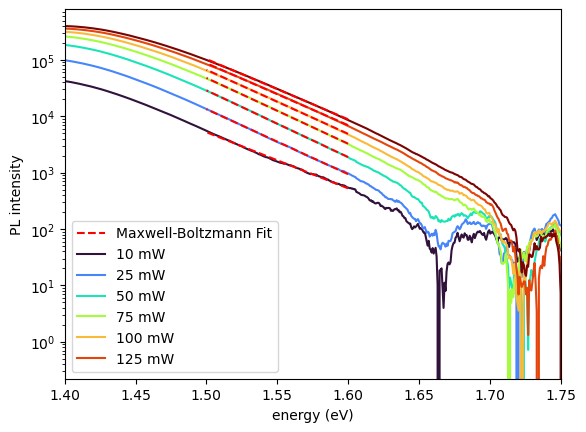

C+P
10 mW: 406.03 K
25 mW: 395.88 K
50 mW: 398.13 K
75 mW: 403.77 K
100 mW: 416.68 K
125 mW: 428.45 K
150 mW: 439.96 K


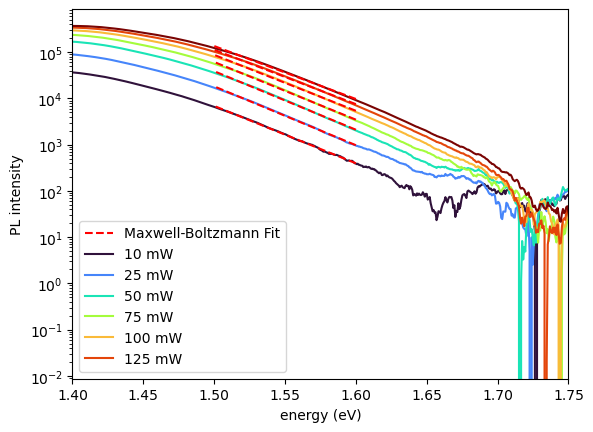

NS
10 mW: 442.05 K
25 mW: 409.24 K
50 mW: 403.0 K
100 mW: 420.09 K
125 mW: 432.66 K
150 mW: 444.96 K


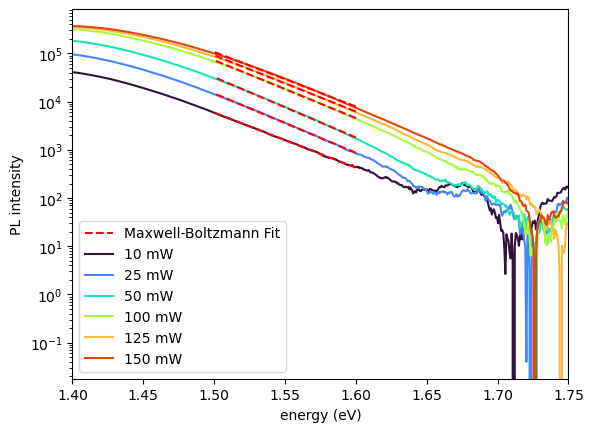

NS+P
10 mW: 420.91 K
25 mW: 374.63 K
50 mW: 387.99 K
75 mW: 405.63 K
100 mW: 425.4 K
125 mW: 447.41 K
150 mW: 473.26 K


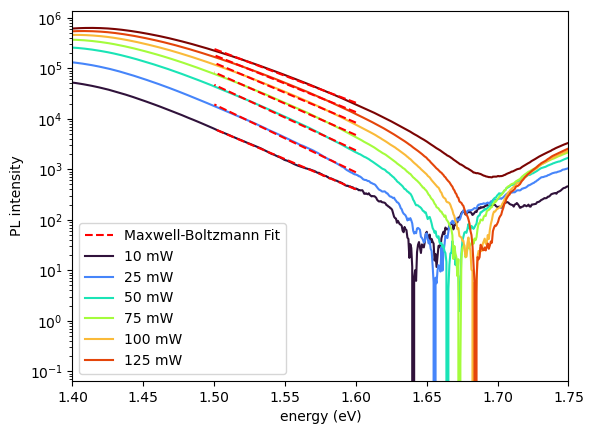

P
10 mW: 574.76 K
25 mW: 491.96 K
50 mW: 456.96 K
75 mW: 461.63 K
100 mW: 471.81 K
125 mW: 486.73 K
150 mW: 512.55 K


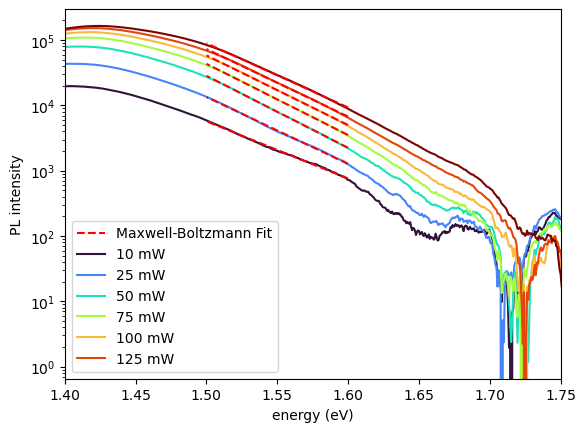

P+P
10 mW: 445.34 K
25 mW: 410.89 K
50 mW: 408.04 K
75 mW: 419.53 K
100 mW: 429.68 K
125 mW: 446.75 K
150 mW: 462.39 K


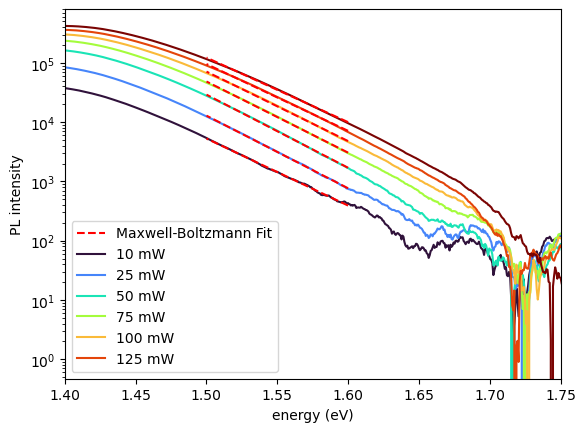

PS
10 mW: 397.81 K
25 mW: 414.42 K
50 mW: 424.73 K
75 mW: 435.21 K
100 mW: 449.78 K
125 mW: 466.84 K
150 mW: 483.43 K


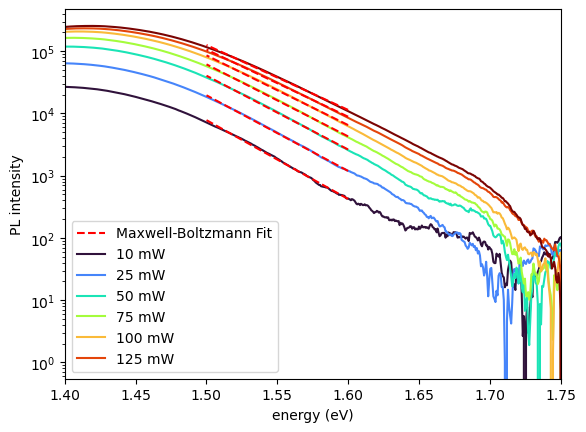

PS+P
10 mW: 483.32 K
25 mW: 472.77 K
50 mW: 488.89 K
75 mW: 510.06 K
100 mW: 532.41 K
125 mW: 558.07 K
150 mW: 586.41 K


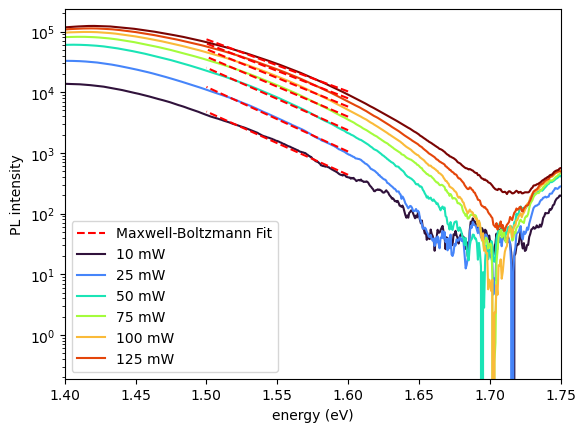

,TC_high,TC_del,TC_low
C,471.491306,34.423918,437.067388
C+P,439.962120,44.083337,395.878783
NS,444.958817,35.722715,409.236101
NS+P,473.259779,98.627002,374.632777
P,512.551227,20.588649,491.962578
P+P,462.387672,51.499641,410.888031
PS,483.430423,69.012780,414.417644
PS+P,586.405024,113.637947,472.767078


In [72]:
kB = 8.6173324e-5 # eV/K 

n=len(power)
color=plt.cm.turbo(np.linspace(0, 1, n))

def func(x,a,b):
    return a*x+b

TC_del=pd.Series(index=folderlist,name='TC_del',dtype=float)
TC_high=pd.Series(index=folderlist,name='TC_high',dtype=float)
TC_low=pd.Series(index=folderlist,name='TC_low',dtype=float)

for s in folderlist:
    print(s)
    TCdf=pd.DataFrame()
    i=0
    
    e_llim=1.5    # fit lower limit
    e_ulim=1.6    # fit upper limit
        
    for p in power:
        if pd.isna(flist[s][int(p)]):
            collection_pk.append(np.nan)
            collection_infl.append(np.nan)
            continue
        PLdata=pd.read_csv(path+s+'\\'+str(flist[s][int(p)]),header=None,names=['nm','intensity'],sep="\t")
        eph=1240/wav
        PLint=pd.Series(PLdata['intensity'],dtype=float)
        
        # rolling average smoothing + background subtracting
        PLint = PLint.iloc[:].rolling(window=50).mean().fillna(method='bfill')
        PLint = PLint.sub(PLint.min())

        eph_=[]
        PLint_=[]

        # defining fit limits
        for e in range(len(eph)):
            if eph[e]>e_llim and eph[e]<e_ulim:
                eph_.append(eph[e])
                PLint_.append(int(PLint[e]))

        # removing -infs
        TCdf[s]=np.log(PLint_)
        for q in range(len(TCdf[s])):
            if np.isneginf(TCdf[s][q]):
                TCdf[s][q]=0
        
        plt.semilogy(eph,PLint,c=color[i],label=p+' mW')
        
        popt, pcov = curve_fit(func,eph_,TCdf[s])
        tc=-1/(popt[0]*kB)
        print(str(p)+' mW: '+str(round(tc,2))+' K')

        fit=[]
        for f in range(len(eph_)):
            fit.append(func(eph_[f],popt[0],popt[1]))
        if p == power[0]:
            plt.semilogy(eph_,np.exp(fit),'r--',label='Maxwell-Boltzmann Fit')
        else:     
            plt.semilogy(eph_,np.exp(fit),'r--')
        plt.xlim(1.4,1.75)
        plt.xlabel('energy (eV)')
        plt.ylabel('PL intensity')
        
        if p == power[1]:
            TC_low[s]=tc
        
        if p == power[-1]:
            TC_del[s]=tc-TC_low[s]
            TC_high[s]=tc
        
        i+=1
    handles, labels = plt.gca().get_legend_handles_labels()
    order=[1,0]+np.linspace(2,len(power)-1,len(power)-2,dtype=int).tolist()
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    plt.show()

TCmaster=pd.DataFrame()
TCmaster['TC_high']=TC_high
TCmaster['TC_del']=TC_del
TCmaster['TC_low']=TC_low
display(TCmaster)

# TCmaster.to_csv(path+'TCparams.csv')
# plt.savefig(path+s+'_TC_fit.png',dpi=300)